In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [2]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))

print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [3]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [6]:
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()

In [7]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [50] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [8]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 111


In [9]:
#Theta Initialization 
#np.random.seed(1)
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]
        theta.append(np.random.normal(0,0.01, (dim0,dim1)))
        #theta.append(0.01*(2*np.random.random((dim0, dim1))-1))
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [10]:
def activation(x):
    return 1/(1+np.exp(-x))

In [127]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        fm.append(activation(np.dot(fm[l], theta[l])))
        if (l!=len(theta)-1):
            fm[l+1]=np.hstack((np.ones((fm[l+1].shape[0],1)),fm[l+1]))
    return fm

In [128]:
theta = theta_init([50,50])
print(len(theta))
for i in range(len(theta)):
    print(i)
fm = forward_prop(X_train, theta)
#print(fm.shape)
print(fm[1].shape)
print(theta[2].shape)
#np.hstack((fm,np.ones((fm.shape[0],1))))

3
0
1
2
(11050, 51)
(51, 26)


In [120]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [121]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [122]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

plt_epoch = []
plt_train_acc = []
plt_val_acc = []
plt_test_acc = []
costs= []

In [143]:
arch_test = [100]

In [ ]:
lr = 0.1
for i in range(len(arch_test)):
    theta = theta_init([arch_test[i]])
    print(theta[0].shape, theta[1].shape)
    early_stop=0
    epoch = 1
    start = time.time()
    cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])

    while(True):
        count = 0
        
        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))

        for b in mini_batch:
            X_b = b[0]
            Y_b = b[1]
            fm = forward_prop(X_b, theta)
            delta = [None]*len(fm)

            if (count % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
            #Backward Propagation

            for l in range(len(fm)-1, 0, -1):
                if (l == len(fm)-1):
                    delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                    #print("delta for last layer = ", delta[l].shape)
                else:
                    delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))
                    #print("delta for hidden layer = ", delta[l][:,1:].shape)


            for t in range(len(theta)):
                if (t == len(theta)-1):
                    theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 
                else:
                    theta[t] += lr*np.dot(fm[t].T, delta[t+1][:,1:]) 
                    
            count+=1
            
#         if epoch %10 == 0:
#                 costs.append(cost_init)
#         if (epoch % 200 == 0):
#             plt_epoch.append(epoch)
#             plt_train_acc.append(calc_accuracy(X_train, theta, train_class_enc))
#             plt_val_acc.append(calc_accuracy(X_valid, theta, valid_class_enc))
#             plt_test_acc.append(calc_accuracy(X_test, theta, test_actual_class_enc))
        
        epoch+=1 #Number of epochs
        
        cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        if (abs(cost_final-cost_init) < 1e-05):
            early_stop +=1
        else:
            early_stop=0
        if (early_stop == 10):
            print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
            break
        cost_init = cost_final
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {:2.3f}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

(785, 100) (101, 26)
Initial Cost on Val dataset for this epoch 1 = 3.24123049615407
Error on this batch = 3.241634014036248
Error on this batch = 0.490405938141527
Cost on val dataset after 2 epochs is = 0.48368019250097555
Initial Cost on Val dataset for this epoch 2 = 0.48368019250097555
Error on this batch = 0.4838952829147013
Error on this batch = 0.4817704479788537
Cost on val dataset after 3 epochs is = 0.4815137783500931
Initial Cost on Val dataset for this epoch 3 = 0.4815137783500931
Error on this batch = 0.4815547645990562
Error on this batch = 0.481303952216963
Cost on val dataset after 4 epochs is = 0.4812654041617647
Initial Cost on Val dataset for this epoch 4 = 0.4812654041617647
Error on this batch = 0.48125478235319324
Error on this batch = 0.4812602745509206
Cost on val dataset after 5 epochs is = 0.4812168753815369
Initial Cost on Val dataset for this epoch 5 = 0.4812168753815369
Error on this batch = 0.4811844488550438
Error on this batch = 0.48126116413518805
Cost

Error on this batch = 0.4805863214216194
Cost on val dataset after 41 epochs is = 0.48046094893952335
Initial Cost on Val dataset for this epoch 41 = 0.48046094893952335
Error on this batch = 0.48036782987453935
Error on this batch = 0.48054815521921146
Cost on val dataset after 42 epochs is = 0.480419676581324
Initial Cost on Val dataset for this epoch 42 = 0.480419676581324
Error on this batch = 0.48032303790170155
Error on this batch = 0.4805080410618549
Cost on val dataset after 43 epochs is = 0.480376112339828
Initial Cost on Val dataset for this epoch 43 = 0.480376112339828
Error on this batch = 0.4802756356930473
Error on this batch = 0.48046584022041827
Cost on val dataset after 44 epochs is = 0.48033008339899774
Initial Cost on Val dataset for this epoch 44 = 0.48033008339899774
Error on this batch = 0.48022542194772494
Error on this batch = 0.4804214034019641
Cost on val dataset after 45 epochs is = 0.4802814029447719
Initial Cost on Val dataset for this epoch 45 = 0.48028140

Error on this batch = 0.4743808137343825
Cost on val dataset after 80 epochs is = 0.4727290211757747
Initial Cost on Val dataset for this epoch 80 = 0.4727290211757747
Error on this batch = 0.47132050742941844
Error on this batch = 0.4738626960317157
Cost on val dataset after 81 epochs is = 0.4720485256967732
Initial Cost on Val dataset for this epoch 81 = 0.4720485256967732
Error on this batch = 0.47050022675347253
Error on this batch = 0.4732977164851602
Cost on val dataset after 82 epochs is = 0.4713091318779413
Initial Cost on Val dataset for this epoch 82 = 0.4713091318779413
Error on this batch = 0.46960804859965144
Error on this batch = 0.4726815541255452
Cost on val dataset after 83 epochs is = 0.4705077893530745
Initial Cost on Val dataset for this epoch 83 = 0.4705077893530745
Error on this batch = 0.4686405289196512
Error on this batch = 0.47200984413954317
Cost on val dataset after 84 epochs is = 0.4696422381328679
Initial Cost on Val dataset for this epoch 84 = 0.469642238

Error on this batch = 0.3912268600729749
Cost on val dataset after 119 epochs is = 0.4005209649677986
Initial Cost on Val dataset for this epoch 119 = 0.4005209649677986
Error on this batch = 0.39288047160722417
Error on this batch = 0.3871535847665055
Cost on val dataset after 120 epochs is = 0.39764767952127233
Initial Cost on Val dataset for this epoch 120 = 0.39764767952127233
Error on this batch = 0.38993508001297633
Error on this batch = 0.38311978236619
Cost on val dataset after 121 epochs is = 0.3947589077286106
Initial Cost on Val dataset for this epoch 121 = 0.3947589077286106
Error on this batch = 0.3869765170058267
Error on this batch = 0.3791720575174989
Cost on val dataset after 122 epochs is = 0.3918707563731406
Initial Cost on Val dataset for this epoch 122 = 0.3918707563731406
Error on this batch = 0.3840284515806958
Error on this batch = 0.3753411125298108
Cost on val dataset after 123 epochs is = 0.38899463837033893
Initial Cost on Val dataset for this epoch 123 = 0.

Error on this batch = 0.2753861709773545
Cost on val dataset after 158 epochs is = 0.29518418249750294
Initial Cost on Val dataset for this epoch 158 = 0.29518418249750294
Error on this batch = 0.2823528522890709
Error on this batch = 0.2729090132015801
Cost on val dataset after 159 epochs is = 0.29283467594240914
Initial Cost on Val dataset for this epoch 159 = 0.29283467594240914
Error on this batch = 0.27978357866044634
Error on this batch = 0.27045222342626996
Cost on val dataset after 160 epochs is = 0.29050930197198993
Initial Cost on Val dataset for this epoch 160 = 0.29050930197198993
Error on this batch = 0.27724813873944565
Error on this batch = 0.26801623557978477
Cost on val dataset after 161 epochs is = 0.28820823270654916
Initial Cost on Val dataset for this epoch 161 = 0.28820823270654916
Error on this batch = 0.27474681381663973
Error on this batch = 0.2656012462109542
Cost on val dataset after 162 epochs is = 0.28593150873745743
Initial Cost on Val dataset for this epo

Error on this batch = 0.19346312778794011
Cost on val dataset after 197 epochs is = 0.22055868532697598
Initial Cost on Val dataset for this epoch 197 = 0.22055868532697598
Error on this batch = 0.20461030036472913
Error on this batch = 0.19179385858217168
Cost on val dataset after 198 epochs is = 0.2191221903453837
Initial Cost on Val dataset for this epoch 198 = 0.2191221903453837
Error on this batch = 0.20307329806028152
Error on this batch = 0.19014805360205786
Cost on val dataset after 199 epochs is = 0.2177112845302886
Initial Cost on Val dataset for this epoch 199 = 0.2177112845302886
Error on this batch = 0.20155306493221736
Error on this batch = 0.18852551182422653
Cost on val dataset after 200 epochs is = 0.21632583794190927
Initial Cost on Val dataset for this epoch 200 = 0.21632583794190927
Error on this batch = 0.20004967518887423
Error on this batch = 0.18692599756632722
Cost on val dataset after 201 epochs is = 0.2149656864355621
Initial Cost on Val dataset for this epoc

Error on this batch = 0.14306969852993653
Cost on val dataset after 236 epochs is = 0.180710857821793
Initial Cost on Val dataset for this epoch 236 = 0.180710857821793
Error on this batch = 0.1574872360893825
Error on this batch = 0.14210702386848797
Cost on val dataset after 237 epochs is = 0.18002672096973762
Initial Cost on Val dataset for this epoch 237 = 0.18002672096973762
Error on this batch = 0.1566026055581108
Error on this batch = 0.1411581336983001
Cost on val dataset after 238 epochs is = 0.17935432415291155
Initial Cost on Val dataset for this epoch 238 = 0.17935432415291155
Error on this batch = 0.15573141820914174
Error on this batch = 0.14022286229654485
Cost on val dataset after 239 epochs is = 0.17869335478868476
Initial Cost on Val dataset for this epoch 239 = 0.17869335478868476
Error on this batch = 0.15487342410375615
Error on this batch = 0.139301043394113
Cost on val dataset after 240 epochs is = 0.17804350883658218
Initial Cost on Val dataset for this epoch 24

Cost on val dataset after 275 epochs is = 0.16049603918241223
Initial Cost on Val dataset for this epoch 275 = 0.16049603918241223
Error on this batch = 0.13090916138812975
Error on this batch = 0.11366533094363991
Cost on val dataset after 276 epochs is = 0.16010437318066265
Initial Cost on Val dataset for this epoch 276 = 0.16010437318066265
Error on this batch = 0.130392316417291
Error on this batch = 0.11312520893107612
Cost on val dataset after 277 epochs is = 0.15971721087315696
Initial Cost on Val dataset for this epoch 277 = 0.15971721087315696
Error on this batch = 0.1298816088923717
Error on this batch = 0.11259249162447715
Cost on val dataset after 278 epochs is = 0.15933445836385668
Initial Cost on Val dataset for this epoch 278 = 0.15933445836385668
Error on this batch = 0.12937691996930994
Error on this batch = 0.11206704503112686
Cost on val dataset after 279 epochs is = 0.15895602451552698
Initial Cost on Val dataset for this epoch 279 = 0.15895602451552698
Error on thi

In [140]:
calc_accuracy(X_test, theta, test_actual_class_enc)
# epochs
# train_accuracy
# test_accuracy
# valid_accuracy
# train_time

88.38461538461539

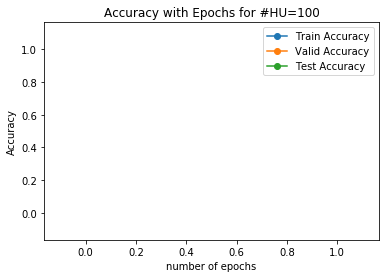

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with Epochs for #HU=100")
#x = np.arange(0,len(costs))
ax.plot(plt_epoch, plt_train_acc, marker='o', label='Train Accuracy')
ax.plot(plt_epoch, plt_val_acc, marker='o', label='Valid Accuracy')
ax.plot(plt_epoch, plt_test_acc, marker='o', label='Test Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Accuracy")

plt.legend()
#plt.savefig("plots/val_loss/accuracy_HiddenUnit100_valloss15per.png", dpi=1000, bbox_inches='tight')
plt.show()

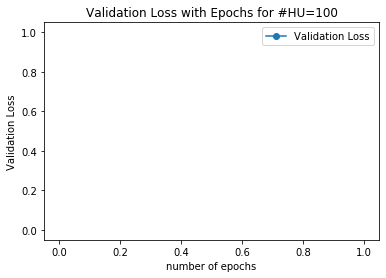

In [114]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Validation Loss with Epochs for #HU=100")
x = np.arange(0,len(costs))
ax.plot(x, costs, marker='o', label='Validation Loss')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Validation Loss")

plt.legend()
#plt.savefig("plots/val_loss/partb_val_loss15per_100units.png", dpi=1000, bbox_inches='tight')
plt.show()

In [50]:
len(costs)

17649

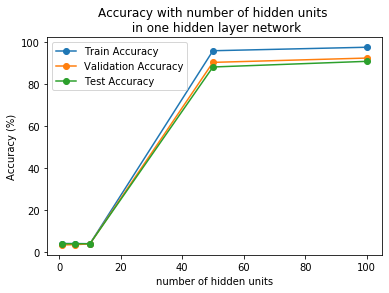

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with number of hidden units \n in one hidden layer network")
ax.plot(arch_test, train_accuracy, marker='o', label='Train Accuracy')
ax.plot(arch_test, valid_accuracy, marker='o',label='Validation Accuracy')
ax.plot(arch_test, test_accuracy, marker='o', label='Test Accuracy')
ax.set_xlabel("number of hidden units")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

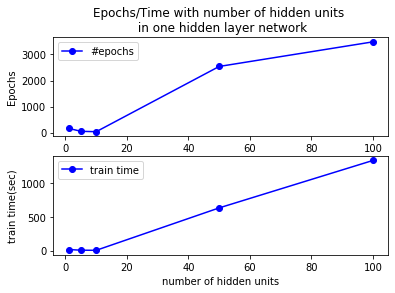

In [116]:
fig = plt.figure()
ax = fig.add_subplot(211)
plt.title("Epochs/Time with number of hidden units \n in one hidden layer network")
ax.plot(arch_test, epochs, c='b', marker='o', label='#epochs')
ax.set_xlabel("number of hidden units")
ax.set_ylabel("Epochs")
ax.legend()

ax1 = fig.add_subplot(212)
ax1.plot(arch_test, train_time, c='b', marker='o', label='train time')
ax1.set_xlabel("number of hidden units")
ax1.set_ylabel("train time(sec)")
plt.legend()
#plt.savefig("epochs_time_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy with number of epochs for \n 1 hidden layer of 100 units")
ax.plot(plt_epoch, plt_train_acc, c='b', label='Train Accuracy')
ax.plot(plt_epoch, plt_val_acc, c='m',label='Validation Accuracy')
ax.plot(plt_epoch, plt_test_acc, c='g', label='Test Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Accuracy (%)")

plt.legend()
#plt.savefig("accuracy_epoch_100_valloss.png", dpi=1000, bbox_inches='tight')
plt.show()